In [24]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas_profiling

%matplotlib inline

Представлены данные такси, по которым мы должны предсказать возьмёт ли таксист заказ или нет(driver_response)
### Задание 1 -  Загрузите датасет taxi.csv 

In [55]:
data = pd.read_csv('taxi.csv')
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


### Задание 2 - Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [57]:
wd = data['weekday_key'].unique()
wd

array([5, 6, 2, 4, 3, 1, 0])

In [58]:
hk = data['hour_key'].unique()
hk

array([20, 14,  6, 16, 15, 11,  7, 10, 12,  8,  9, 21, 17, 23, 13, 18,  5,
       19, 22,  0,  2,  3,  1,  4])

Наблюдения:
+ Нет пропусков. Все признаки обладают равным числом ненулевых значений - 100к
+ Дни недели и часы начинаются с нуля - нет отрицательных значений или значений, выходящих за рамки числа возможных вариантов
+ долгота и ширина - хорошие показатели для расчета расстояния, но не для нашего упражнения, где расстояние посчитано
+ дистанция и длительность - есть отрицательные и аномально высокие положительные значения. Проверить
+ driver response - наш целевой признак, принимает значения 0 или 1. Проверить что нет промежуточных

### Задание 3 - Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.

Пропусков нет.

### Задание 4 - Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.

In [25]:
data.profile_report()

+ снова убеждаемся что нет нулей. нет дубликатов
+ долгота и широта сильно коррелируют. вероятно мы откажется от признаков
+ в часах и днях много нулей - это нормально, понедельник и полночь
+ есть слабая корреляция между ответом водителя и временем / дистанцией
+ дистанция и время прибытия сильно коррелируют (что неудивительно) - будем убирать один признак чтобы избежать переобучения
+ дистанция распределена крайне неравномерно. Исследуем
+ снова видим отрицательную дистанцию - проверить, их больше 26% от всей выборки, также видим аномально большую дистанцию
+ Уникальных водителей всего 439
+ Ответ водителя всегда 0 или 1. это нам подходит
+ чаще всего заказы совершались в вечерние и ночные часы - все логично
+ есть 9 классов заказов, но один из них называется Test - вероятно лишний
+ все номера предложений уникальные - их 100к
+ уникальных номеров заказов - 81.4% . непонятно
+ есть 4 уникальных типа поездки 
+ больше всего поездок совершается в выходные (если предположить что понедельник это 0)
+ Принятых заказов 49% . Это немного развязывает нам руки в части требований к точности модели (если бы было принято 99% заказов у нас были бы проблемы)

### Задание 5 - Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).

категориальных признака 4 - день недели, час, класс заказа и тип поездки
+ к дням недели и часам уже примененм lableencoder - т.к. это упорядоченные значения, попробуем их сохранить такими, т.к. мы собираемся строить RandomForest и это нам не помешает
+ класс заказа и тип поездки - не упорядочены, к ним применим one hot encoding, чтобы избежать ложных интерпретаций

### Задание 6 - Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости

**Для начала уберем лишние признаки - долготу и широту**

In [59]:
data = data.drop(['driver_latitude'], axis=1)
data = data.drop(['driver_longitude'], axis=1)
data = data.drop(['origin_order_latitude'], axis=1)
data = data.drop(['origin_order_longitude'], axis=1)

был класс заказа test - уберем и его (8 записей)

In [60]:
data = data[data['offer_class_group'] != 'Test']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99992 entries, 0 to 99999
Data columns (total 10 columns):
offer_gk             99992 non-null int64
weekday_key          99992 non-null int64
hour_key             99992 non-null int64
driver_gk            99992 non-null int64
order_gk             99992 non-null int64
distance_km          99992 non-null float64
duration_min         99992 non-null float64
offer_class_group    99992 non-null object
ride_type_desc       99992 non-null object
driver_response      99992 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 8.4+ MB


У длительности и дистанции были отрицательные и нулевые значения - посмотрим, в одинаковых ли случаях.

In [70]:
data[data['distance_km'] <=0].count()

offer_gk             26351
weekday_key          26351
hour_key             26351
driver_gk            26351
order_gk             26351
distance_km          26351
duration_min         26351
offer_class_group    26351
ride_type_desc       26351
driver_response      26351
dtype: int64

In [71]:
data[data['duration_min'] <=0].count()

offer_gk             26351
weekday_key          26351
hour_key             26351
driver_gk            26351
order_gk             26351
distance_km          26351
duration_min         26351
offer_class_group    26351
ride_type_desc       26351
driver_response      26351
dtype: int64

Даже если в этом и есть какой-то практический смысл, в реальной жизни такого не бывает. Уберем их, а также нулевые

In [72]:
data = data[data['duration_min']>0]

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73641 entries, 1 to 99999
Data columns (total 10 columns):
offer_gk             73641 non-null int64
weekday_key          73641 non-null int64
hour_key             73641 non-null int64
driver_gk            73641 non-null int64
order_gk             73641 non-null int64
distance_km          73641 non-null float64
duration_min         73641 non-null float64
offer_class_group    73641 non-null object
ride_type_desc       73641 non-null object
driver_response      73641 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 6.2+ MB


Расстояние и длительность, коррелируют между собой. Уберем расстояние, т.к. длительность вероятно чуть ближе к принятию решения о поездке, т.к. учитывает пробки и особенности организации движения

In [74]:
data = data.drop(['distance_km'], axis=1)

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73641 entries, 1 to 99999
Data columns (total 9 columns):
offer_gk             73641 non-null int64
weekday_key          73641 non-null int64
hour_key             73641 non-null int64
driver_gk            73641 non-null int64
order_gk             73641 non-null int64
duration_min         73641 non-null float64
offer_class_group    73641 non-null object
ride_type_desc       73641 non-null object
driver_response      73641 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 5.6+ MB


Исследуем длительность на предмет выбросов

In [94]:
data[data['duration_min'] > 1000]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,duration_min,offer_class_group,ride_type_desc,driver_response
6110,198416,4,17,2333,914494,1014.283,Standard,private,0
10089,873470,1,16,6580,660752,1149.667,Standard,private,0
13973,174541,1,20,5714,706021,1254.050,Economy,private,1
14331,391059,6,15,2410,633727,1159.000,XL,private,1
37485,552747,1,18,6666,219128,3947.383,VIP,private,1
37639,538141,6,18,994,463224,3112.217,Standard,private,1
53607,106985,2,12,1420,225632,1389.567,Economy,private,1
67891,168924,6,21,989,452759,1019.000,Economy,private,1
77201,158777,2,20,3309,636962,2721.000,Standard,private,1
89462,689042,5,22,2272,247073,1680.850,Standard,private,1


In [95]:
data[data['duration_min'] > 180].count()

offer_gk             69
weekday_key          69
hour_key             69
driver_gk            69
order_gk             69
duration_min         69
offer_class_group    69
ride_type_desc       69
driver_response      69
dtype: int64

+ Есть элементы с аномально высокой длительностью. Однако почти все эти заказы были приняты. Не будем пока их убирать.
+ 69 элементов (менее 0.1%) имеют длительность свыше 3 часов (из Зеленограда в Домодедово с небольшими пробками). пока остаим все это

Номер предложения и номер заказа уберем - это id, на решение о поездке не влияют

In [96]:
data = data.drop(['offer_gk'], axis=1)
data = data.drop(['order_gk'], axis=1)

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73641 entries, 1 to 99999
Data columns (total 7 columns):
weekday_key          73641 non-null int64
hour_key             73641 non-null int64
driver_gk            73641 non-null int64
duration_min         73641 non-null float64
offer_class_group    73641 non-null object
ride_type_desc       73641 non-null object
driver_response      73641 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 4.5+ MB


***One Hot Encoding для класса заказа***

In [99]:
from sklearn import preprocessing

In [194]:
offer_class_group = data['offer_class_group'].get_values().reshape(-1, 1)

In [195]:
data['offer_class_group'].value_counts()

Economy     40764
Standard    29857
Premium      1005
Delivery      884
Kids          568
XL            444
VIP           108
VIP+           11
Name: offer_class_group, dtype: int64

In [196]:
offer_names = ['Delivery', 'Economy', 'Kids', 'Premium', 'Standard', 'VIP', 'VIP+', 'XL']

In [197]:
oh_encoder = preprocessing.OneHotEncoder()
oh_encoder.fit(offer_class_group)
oh_result_1 = oh_encoder.transform(offer_class_group).toarray()
offer_class_df = pd.DataFrame(oh_result_1, columns=offer_names)
offer_class_df.index = data.index
offer_class_df.head()

,Delivery,Economy,Kids,Premium,Standard,VIP,VIP+,XL
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
data_upd= pd.concat([data, offer_class_df], axis=1)
data_upd.head()

,weekday_key,hour_key,driver_gk,duration_min,offer_class_group,ride_type_desc,driver_response,Delivery,Economy,Kids,Premium,Standard,VIP,VIP+,XL
1,5,14,6080,25.217,Standard,private,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,6,14,6080,9.800,Economy,private,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,16,6080,19.250,Economy,private,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,15,6080,9.800,Economy,private,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5,20,6080,3.933,Economy,private,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


***One Hot Encoding для типа поездки***

In [199]:
ride_type_desc = data['ride_type_desc'].get_values().reshape(-1, 1)

In [200]:
data['ride_type_desc'].value_counts()

private     73460
business      162
SMB            19
Name: ride_type_desc, dtype: int64

In [201]:
ride_names = ['SMB', 'business', 'private']

In [202]:
oh_encoder.fit(ride_type_desc)
oh_result_2 = oh_encoder.transform(ride_type_desc).toarray()
ride_type_df = pd.DataFrame(oh_result_2, columns=ride_names)
ride_type_df.index = data.index
ride_type_df.head()

,SMB,business,private
1,0.0,0.0,1.0
2,0.0,0.0,1.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0
7,0.0,0.0,1.0


In [203]:
data_upd = pd.concat([data_upd, ride_type_df], axis=1)
data_upd.head()

,weekday_key,hour_key,driver_gk,duration_min,offer_class_group,ride_type_desc,driver_response,Delivery,Economy,Kids,Premium,Standard,VIP,VIP+,XL,SMB,business,private
1,5,14,6080,25.217,Standard,private,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,6,14,6080,9.800,Economy,private,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,16,6080,19.250,Economy,private,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,6,15,6080,9.800,Economy,private,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,5,20,6080,3.933,Economy,private,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Удаляем оставшиеся ненужные два столбца

In [204]:
data_upd = data_upd.drop(['ride_type_desc'], axis=1)
data_upd = data_upd.drop(['offer_class_group'], axis=1)

In [205]:
data_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73641 entries, 1 to 99999
Data columns (total 16 columns):
weekday_key        73641 non-null int64
hour_key           73641 non-null int64
driver_gk          73641 non-null int64
duration_min       73641 non-null float64
driver_response    73641 non-null int64
Delivery           73641 non-null float64
Economy            73641 non-null float64
Kids               73641 non-null float64
Premium            73641 non-null float64
Standard           73641 non-null float64
VIP                73641 non-null float64
VIP+               73641 non-null float64
XL                 73641 non-null float64
SMB                73641 non-null float64
business           73641 non-null float64
private            73641 non-null float64
dtypes: float64(12), int64(4)
memory usage: 9.6 MB


Остались:
+ день недели, час, id водителя, длительность поездки, ответ водителя (будущий таргет)
+ 8 колонок с классом заказа и 3 колонки с типом поездки
+ Итого 16 колонок

Превратим таргет в две колонки - принято и нет

In [206]:
def accepted(a):
    if a == 1:
        return 1
    else:
        return 0

def not_accepted(a):
    if a == 1:
        return 0
    else:
        return 1

In [208]:
data_upd['accepted'] = data_upd['driver_response'].apply(accepted)
data_upd['not_accepted'] = data_upd['driver_response'].apply(not_accepted)

In [210]:
data_upd.head()

,weekday_key,hour_key,driver_gk,duration_min,driver_response,Delivery,Economy,Kids,Premium,Standard,VIP,VIP+,XL,SMB,business,private,accepted,not_accepted
1,5,14,6080,25.217,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
2,6,14,6080,9.800,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
4,4,16,6080,19.250,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
5,6,15,6080,9.800,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
7,5,20,6080,3.933,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1


Убираем колонку с ответом водителя

In [211]:
data_upd = data_upd.drop(['driver_response'], axis=1)

In [213]:
data_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73641 entries, 1 to 99999
Data columns (total 17 columns):
weekday_key     73641 non-null int64
hour_key        73641 non-null int64
driver_gk       73641 non-null int64
duration_min    73641 non-null float64
Delivery        73641 non-null float64
Economy         73641 non-null float64
Kids            73641 non-null float64
Premium         73641 non-null float64
Standard        73641 non-null float64
VIP             73641 non-null float64
VIP+            73641 non-null float64
XL              73641 non-null float64
SMB             73641 non-null float64
business        73641 non-null float64
private         73641 non-null float64
accepted        73641 non-null int64
not_accepted    73641 non-null int64
dtypes: float64(12), int64(5)
memory usage: 10.1 MB


### Задание 7 - Разделите выборку на обучаемую и тестовую.

17 колонок. первые 15 - атрибуты, последние 2 - классы

In [247]:
output_y = data_upd.iloc[:,15:]
input_x = data_upd.iloc[:,:15]

In [248]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

not_accepted    38901
accepted        34740
dtype: int64


Возьмем соотношение 25/75

In [249]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.25)

### Задание 8 - Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

No handles with labels found to put in legend.


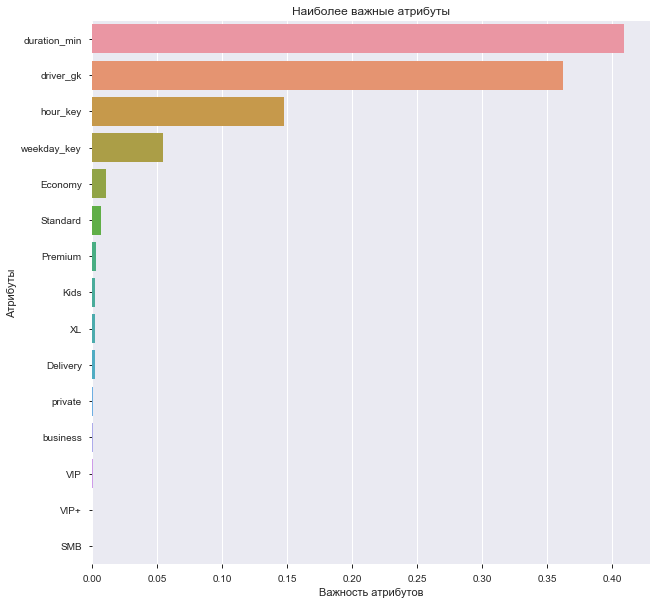

In [250]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель random forest
model=RandomForestClassifier(n_estimators=500)

# обучаем модель
model.fit(x_train,y_train)

headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [251]:
model.score(x_test, y_test)

0.7510727282602792

Точность модели всего 75%
+ этого явно недостаточно
+ мы видим что id водителя влияет на принятие решения, но здесь может быть скрыта ловушка - например каким-то водителям с низким числом заказов 'не везет' с заказами, которые они не хотят применять
+ время суток влияет гораздо сильнее чем день недели
+ попробуем убрать id водителя

**Подход к снаряду номер 2**

In [252]:
data_upd_2 = data_upd.drop(['driver_gk'], axis = 1)
data_upd_2.head()

,weekday_key,hour_key,duration_min,Delivery,Economy,Kids,Premium,Standard,VIP,VIP+,XL,SMB,business,private,accepted,not_accepted
1,5,14,25.217,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
2,6,14,9.800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
4,4,16,19.250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
5,6,15,9.800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
7,5,20,3.933,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1


In [253]:
output_y = data_upd_2.iloc[:,14:]
input_x = data_upd_2.iloc[:,:14]

In [254]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

not_accepted    38901
accepted        34740
dtype: int64


In [255]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.25)

No handles with labels found to put in legend.


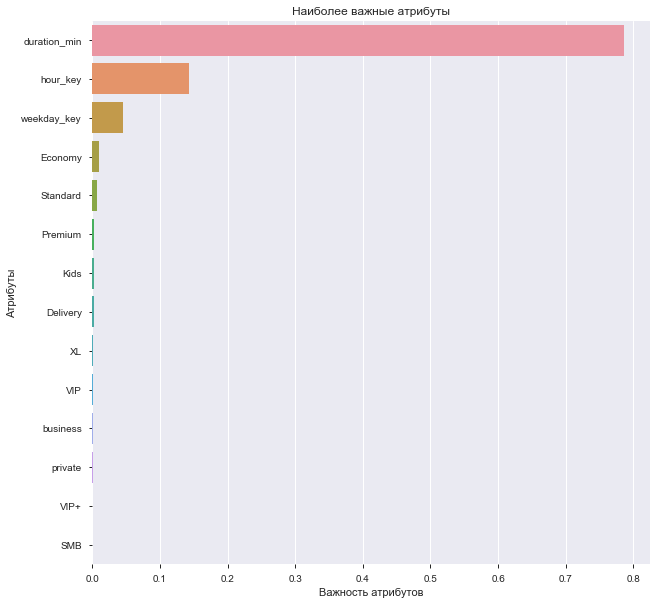

In [256]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель random forest
model=RandomForestClassifier(n_estimators=500)

# обучаем модель
model.fit(x_train,y_train)

headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [257]:
model.score(x_test, y_test)

0.6642224756938787

Результат ухудшился. Все-таки id водителя влиял - видимо есть более разборчивые водители, чем остальные

**Подход к снаряду номер 3 - оставим водителя, но уберем тип поездки**

In [280]:
data_upd_3 = data_upd.iloc[ : ,  [0,1,2,3,4,5,6,7,8,9,10,11,15,16]  ]
data_upd_3.head()

,weekday_key,hour_key,driver_gk,duration_min,Delivery,Economy,Kids,Premium,Standard,VIP,VIP+,XL,accepted,not_accepted
1,5,14,6080,25.217,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
2,6,14,6080,9.800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,4,16,6080,19.250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
5,6,15,6080,9.800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
7,5,20,6080,3.933,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [284]:
output_y = data_upd_3.iloc[:,12:]
input_x = data_upd_3.iloc[:,:12]

In [285]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

not_accepted    38901
accepted        34740
dtype: int64


In [286]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.25)

No handles with labels found to put in legend.


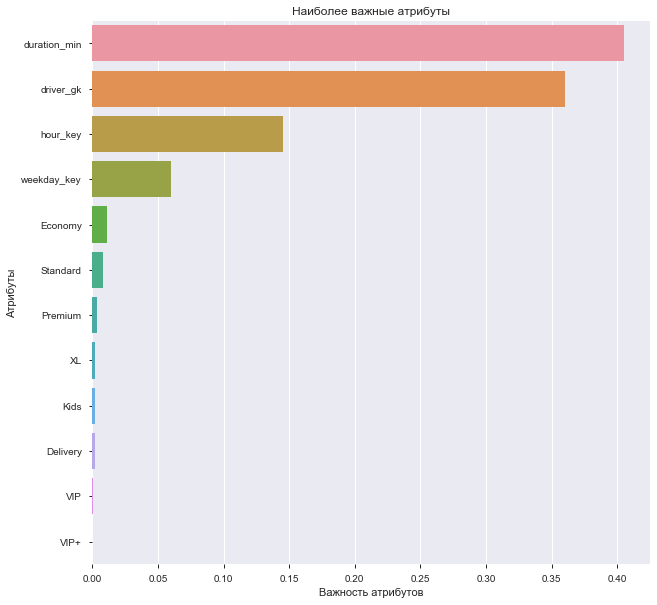

In [287]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель random forest
model=RandomForestClassifier(n_estimators=500)

# обучаем модель
model.fit(x_train,y_train)

headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [288]:
model.score(x_test, y_test)

0.7530823963934604

Те же 75%

**Подход 4 - из получившегося результата уберем водителя**

In [289]:
data_upd_4 = data_upd_3.drop('driver_gk', axis=1)
data_upd_4.head()

,weekday_key,hour_key,duration_min,Delivery,Economy,Kids,Premium,Standard,VIP,VIP+,XL,accepted,not_accepted
1,5,14,25.217,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
2,6,14,9.800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,4,16,19.250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
5,6,15,9.800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
7,5,20,3.933,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [293]:
output_y = data_upd_4.iloc[:,11:]
input_x = data_upd_4.iloc[:,:11]

In [294]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

not_accepted    38901
accepted        34740
dtype: int64


In [295]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.25)

No handles with labels found to put in legend.


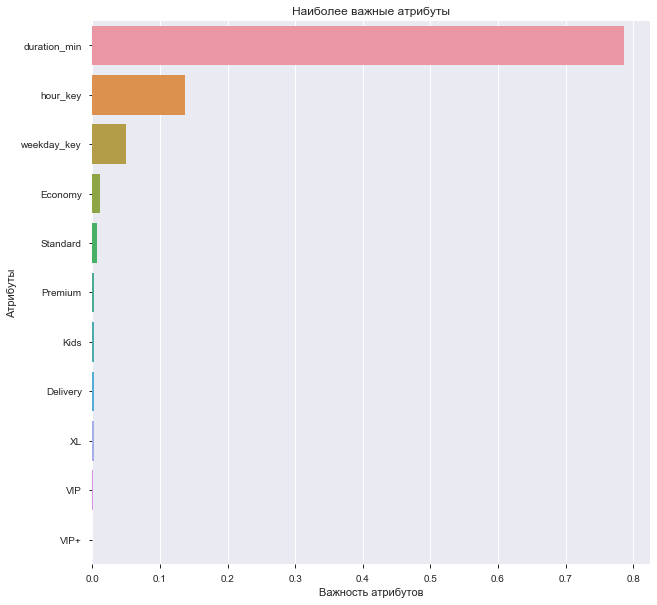

In [296]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель random forest
model=RandomForestClassifier(n_estimators=500)

# обучаем модель
model.fit(x_train,y_train)

headers = list(x_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [297]:
model.score(x_test, y_test)

0.6657976209874531

И все-таки водителя убирать нельзя